# Load Library & Preprocess Data

In [1]:
import random, os, math
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import *


import scipy.ndimage as ndi
import posenet

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Hyperparameter 

In [3]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 8
mode = 'mobilenet_v1'
EPOCHS = 100

alpha = .25
gamma = 2

ckpt_path = '20200816_more_deep_layer'

In [4]:
TRAIN_ROOT_PATH = f'../../Datasets/mpii_human_pose_v1'
pd.set_option('display.max_columns', None)
df_ = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_dataset.csv')
df_ = df_.iloc[:, 1:-3]

df_ = df_.iloc[:, [0, 13, 14, 5, 6, 3, 4, 1, 2, 7, 8, 9, 10, 11, 12,
                  15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32, 25, 26, 23, 24, 21, 22]]

spine = (np.array(df_.iloc[:, [15, 16]]) +  np.array(df_.iloc[:, [1, 2]])) // 2

df_ = pd.concat([df_, pd.DataFrame(spine)], axis=1)
df = df_.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                 33, 34, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]
df.rename(columns={0:'spine_X', 1:'spine_Y'}, inplace=True)

df = df.drop(df[df.iloc[:, 1] == -1].index)
df = df.drop(df[df.iloc[:, 17] == -1].index)

df.iloc[:, 0] = TRAIN_ROOT_PATH + f'/images/' + df.iloc[:, 0]
print(len(df))
df.head()

16816


,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [5]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Utils 

In [6]:
def normalize_image(image):
    mean = [0.40789655, 0.44719303, 0.47026116]
    std = [0.2886383, 0.27408165, 0.27809834]
    return ((np.float32(image) / 255.) - mean) / std

def heatmap(keypoints, input_size, output_width=32, output_height=32, sigma=1):
    
    heatmap_result = np.zeros((output_width, output_height, 17))
    offset_result = np.zeros((output_width, output_height, 34))
    displacement_fwd_result = np.zeros((output_width, output_height, 32))
    displacement_bwd_result = np.zeros((output_width, output_height, 32))
    resize_rate_w = output_width / input_size[1]
    resize_rate_h = output_height / input_size[0]
    
    def get_coords(keypoints):
        keypoints = keypoints.reshape(17, 2)
        x_radius = (np.max(keypoints[:,0]) - np.min(keypoints[:,0])) / 8
        y_radius = (np.max(keypoints[:,1]) - np.min(keypoints[:,1])) / 8
        return keypoints, x_radius, y_radius
    
    def get_heatmap(p_x, p_y, sigma):
        X1 = np.linspace(1, output_width, output_height)
        Y1 = np.linspace(1, output_width, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        E2 = 2.0 * sigma ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap
    
    def get_offset(x, y, x_radius, y_radius):
        x_radius = np.max([2, floor(x_radius * resize_rate_h)])
        y_radius = np.max([2, floor(y_radius * resize_rate_w)])
        offset_x = np.zeros((output_width, output_height))
        offset_y = np.zeros((output_width, output_height))
        p_x = floor(x * resize_rate_w)
        p_y = floor(y * resize_rate_h)
        for idx in range(output_width):
            # x - (p_x / resize_rate_w) + (1 / resize_rate_w) * (idx - p_x)
            # y - (p_y / resize_rate_h) + (1 / resize_rate_h) * (idx - p_y)
            if p_y - y_radius <= idx <= p_y + y_radius:
                offset_x[idx,p_x - x_radius:p_x + x_radius] = y - idx / resize_rate_h
            if p_x - x_radius <= idx <= p_x + x_radius:
                offset_y[p_y - y_radius:p_y + y_radius,idx] = x - idx / resize_rate_w
        return offset_x, offset_y
    
    keypoints, x_radius, y_radius = get_coords(keypoints)
    
    for idx, keypoint in enumerate(keypoints):
        if -1 in keypoint: continue
        heatmap = get_heatmap(keypoint[0] * resize_rate_w,
                              keypoint[1] * resize_rate_h,
                              sigma)
        heatmap_result[:,:,idx] = np.maximum(heatmap_result[:,:,idx], heatmap[:,:,0])
        
        offset_x, offset_y = get_offset(keypoint[0], keypoint[1], x_radius, y_radius)
        offset_result[:,:,idx] = offset_x
        offset_result[:,:,17 + idx] = offset_y
    
    return heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result

In [7]:
def draw_heatmap(batch, heatmap_result, offset_result, displacement_fwd_result=None, displacement_bwd_result=None):
        
    plt.figure(figsize=(10, 30))

    ### Heatmap
    for idx in range(17):
        plt.subplot(12,5,idx+1)
        plt.imshow(heatmap_result[batch][:,:,idx])
        plt.colorbar()
        plt.title(idx)

    
    ### Offset
    for idx in range(17):
        plt.subplot(12,5,idx+1+20)
        plt.imshow(offset_result[batch][:,:,idx])
        plt.colorbar()
        plt.title(idx)
        plt.subplot(12,5,idx+18+20)
        plt.imshow(offset_result[batch][:,:,17+idx])
        plt.colorbar()
        plt.title(17+idx)
        plt.show

In [8]:
def get_adjacent(keypoint_coords):
    adjacent_list = []
    list_dic = [(0, 1), (1, 2), (2, 3), (3, 2), (2, 1), (1, 0),
                (0, 4), (4, 5), (5, 6), (6, 5), (5, 4), (4, 0),
                (0, 7), (7, 8), (8, 9), (9, 10), (10, 9), (9, 8),
                (8, 11), (11, 12), (12, 13), (13, 12), (12, 11), (11, 8),
                (8, 14), (14, 15), (15, 16), (16, 15)]
    for start, end in list_dic:
        start_node = keypoint_coords[start]
        end_node = keypoint_coords[end]
        if sum(start_node) == 0 or sum(end_node) == 0: continue
        adjacent_list.append(start_node)
        adjacent_list.append(end_node)
    adjacent_list = np.array(adjacent_list, dtype=np.int32)
    adjacent_list[:, 0], adjacent_list[:, 1] = adjacent_list[:, 1], adjacent_list[:, 0].copy()
    return adjacent_list

def get_keypoints(keypoint_coords):
    result = []
    for p in keypoint_coords:
        if sum(p) == 0: continue
        result.append(p)
    result = np.array(result, dtype=np.int32)
    result[:, 0], result[:, 1] = result[:, 1], result[:, 0].copy()
    return result

def draw_keypoint(keypoints, img):
    for pt in keypoints:
        img = cv2.circle(img, tuple(pt), radius=5, color=(255, 255, 0), thickness=-1)
    return img

def draw_skeleton_and_kepoints(keypoint_coords, img):
    adjacent_list = get_adjacent(keypoint_coords)
    draw_image = cv2.polylines(img, [adjacent_list], isClosed=False, color=(255,0,0), thickness=3)
    cv_keypoints = get_keypoints(keypoint_coords)
    draw_image = draw_keypoint(cv_keypoints, draw_image)
    return draw_image

In [9]:
def within_nms_radius_fast(pose_coords, squared_nms_radius, point):
    if not pose_coords.shape[0]:
        return False
    return np.any(np.sum((pose_coords - point) ** 2, axis=1) <= squared_nms_radius)


def build_part_with_score(score_threshold, local_max_radius, scores):
    parts = []
    num_keypoints = scores.shape[2]
    lmd = 2 * local_max_radius + 1

    for keypoint_id in range(num_keypoints):
        kp_scores = scores[:, :, keypoint_id].copy()
        kp_scores[kp_scores < score_threshold] = 0.
        max_vals = ndi.maximum_filter(kp_scores, size=lmd, mode='constant')
        max_loc = np.logical_and(kp_scores == max_vals, kp_scores > 0)
        max_loc_idx = max_loc.nonzero()
        for y, x in zip(*max_loc_idx):
            parts.append((
                scores[y, x, keypoint_id],
                keypoint_id,
                np.array((y, x))
            ))

    return parts

def get_instance_score_fast(
        exist_pose_coords,
        squared_nms_radius,
        keypoint_scores, keypoint_coords):

    if exist_pose_coords.shape[0]:
        s = np.sum((exist_pose_coords - keypoint_coords) ** 2, axis=2) > squared_nms_radius
        not_overlapped_scores = np.sum(keypoint_scores[np.all(s, axis=0)])
    else:
        not_overlapped_scores = np.sum(keypoint_scores)
    return not_overlapped_scores / len(keypoint_scores)


def decode_single_poses(scores, offsets, NUM_KEYPOINTS=17, nms_radius=20,
                        score_threshold=0.5, LOCAL_MAXIMUM_RADIUS=1, output_stride=256/32):
    pose_scores = np.zeros(1)
    pose_keypoint_scores = np.zeros((1, NUM_KEYPOINTS))
    pose_keypoint_coords = np.zeros((1, NUM_KEYPOINTS, 2))
    
    squared_nms_radius = nms_radius ** 2
    
    scored_parts = build_part_with_score(score_threshold, LOCAL_MAXIMUM_RADIUS, scores)
    scored_parts = sorted(scored_parts, key=lambda x: x[0], reverse=True)
    
    keypoint_scores = np.zeros((NUM_KEYPOINTS))
    keypoint_coords = np.zeros((NUM_KEYPOINTS, 2))
    
    for root_score, root_id, root_coord in scored_parts:
        # print(offsets[root_coord[0], root_coord[1], root_id])
        root_image_coords = root_coord * output_stride + offsets[
            root_coord[0], root_coord[1], root_id]

        if within_nms_radius_fast(
                pose_keypoint_coords[:, root_id, :], squared_nms_radius, root_image_coords):
            continue
            
        keypoint_scores[root_id] = root_score
        keypoint_coords[root_id,:] = root_image_coords
        
        
    pose_scores = get_instance_score_fast(
        pose_keypoint_coords, squared_nms_radius, keypoint_scores, keypoint_coords)

    pose_keypoint_scores = keypoint_scores
    pose_keypoint_coords = keypoint_coords
    
    return [pose_scores], pose_keypoint_scores, pose_keypoint_coords

def decode_single_poses_nooff(scores, offsets, NUM_KEYPOINTS=17, nms_radius=20,
                        score_threshold=0.5, LOCAL_MAXIMUM_RADIUS=1, output_stride=256/32):
    pose_scores = np.zeros(1)
    pose_keypoint_scores = np.zeros((1, NUM_KEYPOINTS))
    pose_keypoint_coords = np.zeros((1, NUM_KEYPOINTS, 2))
    
    squared_nms_radius = nms_radius ** 2
    
    scored_parts = build_part_with_score(score_threshold, LOCAL_MAXIMUM_RADIUS, scores)
    scored_parts = sorted(scored_parts, key=lambda x: x[0], reverse=True)
    
    keypoint_scores = np.zeros((NUM_KEYPOINTS))
    keypoint_coords = np.zeros((NUM_KEYPOINTS, 2))
    
    for root_score, root_id, root_coord in scored_parts:
        root_image_coords = root_coord * output_stride + offsets[
            root_coord[0], root_coord[1], root_id]

        if within_nms_radius_fast(
                pose_keypoint_coords[:, root_id, :], squared_nms_radius, root_image_coords):
            continue
            
        keypoint_scores[root_id] = root_score
        keypoint_coords[root_id,:] = root_image_coords
        
        
    pose_scores = get_instance_score_fast(
        pose_keypoint_coords, squared_nms_radius, keypoint_scores, keypoint_coords)

    pose_keypoint_scores = keypoint_scores
    pose_keypoint_coords = keypoint_coords
    
    return [pose_scores], pose_keypoint_scores, pose_keypoint_coords

In [10]:
# @tf.function
# def build_part_with_score(score_threshold, local_max_radius, scores):
#     score_threshold = 0.5
#     parts = []

#     def parts_append(elements):
#         parts.append(elements)
    
#     for idx in range(17):
#         score = K.max(scores[0][..., idx])
#         if score < score_threshold: continue
#         x = -1.
#         y = -1.
#         for i in range(32):
#             if K.max(scores[0][i,:,idx]) == score:
#                 y = K.cast(K.argmax(scores[0][i,:,idx]), 'float32')
#         for i in range(32):
#             if K.max(scores[0][:,i,idx]) == score:
#                 x = K.cast(K.argmax(scores[0][:,i,idx]), 'float32')
        
#         tf.py_function(parts_append, inp=[[score, idx, x, y]], Tout=[])
#     return parts

# @tf.function
# def decode_single_poses(args):
#     scores, offsets = args
    
#     NUM_KEYPOINTS=17
#     nms_radius=20
#     score_threshold=0.5
#     LOCAL_MAXIMUM_RADIUS=1
#     output_stride=256/32
    
#     squared_nms_radius = nms_radius ** 2
    
#     scored_parts = build_part_with_score(score_threshold, LOCAL_MAXIMUM_RADIUS, scores)
#     return scored_parts

In [11]:
def _nms(heat, kernel=3):
    hmax = K.pool2d(heat, (kernel, kernel), padding='same', pool_mode='max')
    keep = K.cast(K.equal(hmax, heat), K.floatx())
    return heat * keep

def decode_ddd(hm, offset, k, output_stride):
    hm = _nms(hm)
    hm_shape = K.shape(hm)
    offset_shape = K.shape(offset)
    batch, width, cat = hm_shape[0], hm_shape[2], hm_shape[3]
    
    hm_flat = K.reshape(hm, (batch, -1))
    offset_flat = K.reshape(offset, (offset_shape[0], -1, offset_shape[-1]))
    
    def _process_sample(args):
        pass
    
    detections = K.map_fn(_process_sample, [hm_flat, offset_flat], dtype=K.floatx())
    return detections

In [12]:
def add_decoder(model, k=125, output_stride=256/32):
    def _decode(args):
        hm, offset = args
        return decode_ddd(hm, offset, k=k, output_stride=output_stride)
    
    output = Lambda(_decode)([*model.outputs])
    model = tf.keras.Model(model.input, output)
    return model

# DataGenerator 

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_IDs, df, batch_size=4, shuffle=True,
                 random_state=42, image_paths=None, mode='fit',):
        self.list_IDs = list_IDs
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random_state = random_state
        self.image_paths = image_paths
        self.mode = mode
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        list_IDs_batch = [self.list_IDs[i] for i in indexes]

        X, img_hs, img_ws = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, img_hs, img_ws)
            return X, y
        
        elif self.mode == 'predict':
            return X
        
        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
            
    def __generate_X(self, list_IDs_batch):
        X = []
        img_ws = []
        img_hs = []
        for i, ID in enumerate(list_IDs_batch):
            img_path = self.image_paths[ID]
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype(np.float32)
            img /= 255.
            img_hs.append(img.shape[0])
            img_ws.append(img.shape[1])
            
            ### Show Img ###
            # plt.imshow(img)
            # plt.title(f'ID: {ID}, Shape: {img.shape}')
            ################
            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
            X.append(img)
        X = np.array(X)
        return X, img_hs, img_ws
    
    def __generate_y(self, list_IDs_batch, img_hs, img_ws):
        heatmap_result = []
        offset_result = []
        displacement_fwd_result = []
        displacement_bwd_result = []
        for i, ID in enumerate(list_IDs_batch):
            keypoints = df[df.index == ID].iloc[:, 1:].to_numpy()[0]
            hm, offset, _, _ = heatmap(keypoints, input_size=(img_hs[i], img_ws[i]))
            heatmap_result.append(hm)
            offset_result.append(offset)
            # displacement_fwd_result.append(displacement_fwd)
            # displacement_bwd_result.append(displacement_bwd)
            
        heatmap_result = np.array(heatmap_result)
        offset_result = np.array(offset_result)
        # displacement_fwd_result = np.array(displacement_fwd_result)
        # displacement_bwd_result = np.array(displacement_bwd_result)
        
#         return [heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result]
        return [heatmap_result, offset_result]

# Inference 

In [14]:
with tf.device('/device:GPU:1'):
    base_model = posenet.load_model(mode)
    inputs = tf.keras.Input(shape=(256,256,3))
    outputs = base_model(inputs)
    inf_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    inf_model.load_weights(f'./checkpoints/{ckpt_path}.hdf5')

In [15]:
# decode_model = add_decoder(inf_model)

In [16]:
inf_gen = DataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

In [17]:
img, regr = inf_gen.__getitem__(11)
result = inf_model(img)
idx = 0

In [18]:
# hm = _nms(result[0]).numpy()

# plt.figure(figsize=(10, 30))

# ### Heatmap
# for i in range(17):
#     plt.subplot(12,5,i+1)
#     plt.imshow(hm[0][:,:,i])
#     plt.colorbar()
#     plt.title(i)

In [19]:
# hm, hm.shape

In [20]:
# _, inds = tf.math.top_k(K.reshape(hm, (1, 17, 32*32)), k=1)
# inds.numpy().shape, inds

In [21]:
# test = np.array([[[[1,2,3,4],[5,6,7,8],[9,10,11,12]],
#                  [[1,2,3,4],[5,6,7,8],[9,10,11,12]],
#                 [[1,2,3,4],[5,6,7,8],[9,10,11,12]]]])
# test, test.shape

In [22]:
# re = np.reshape(test, (1, 4, 9))
# re, re.shape

In [23]:
# result_decode = decode_model(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


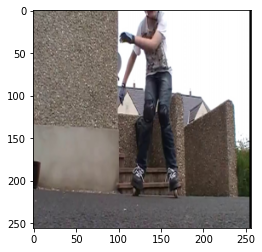

In [24]:
plt.imshow(img[idx])
plt.show()

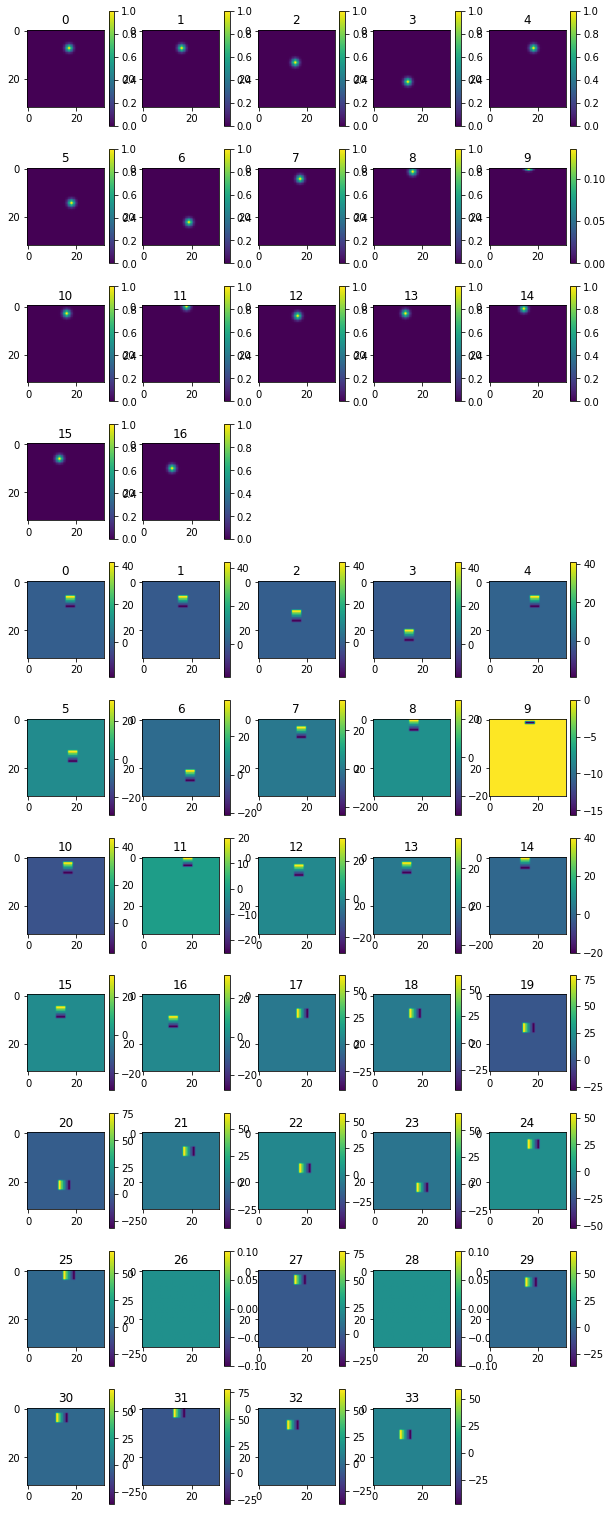

In [25]:
draw_heatmap(0, *regr)

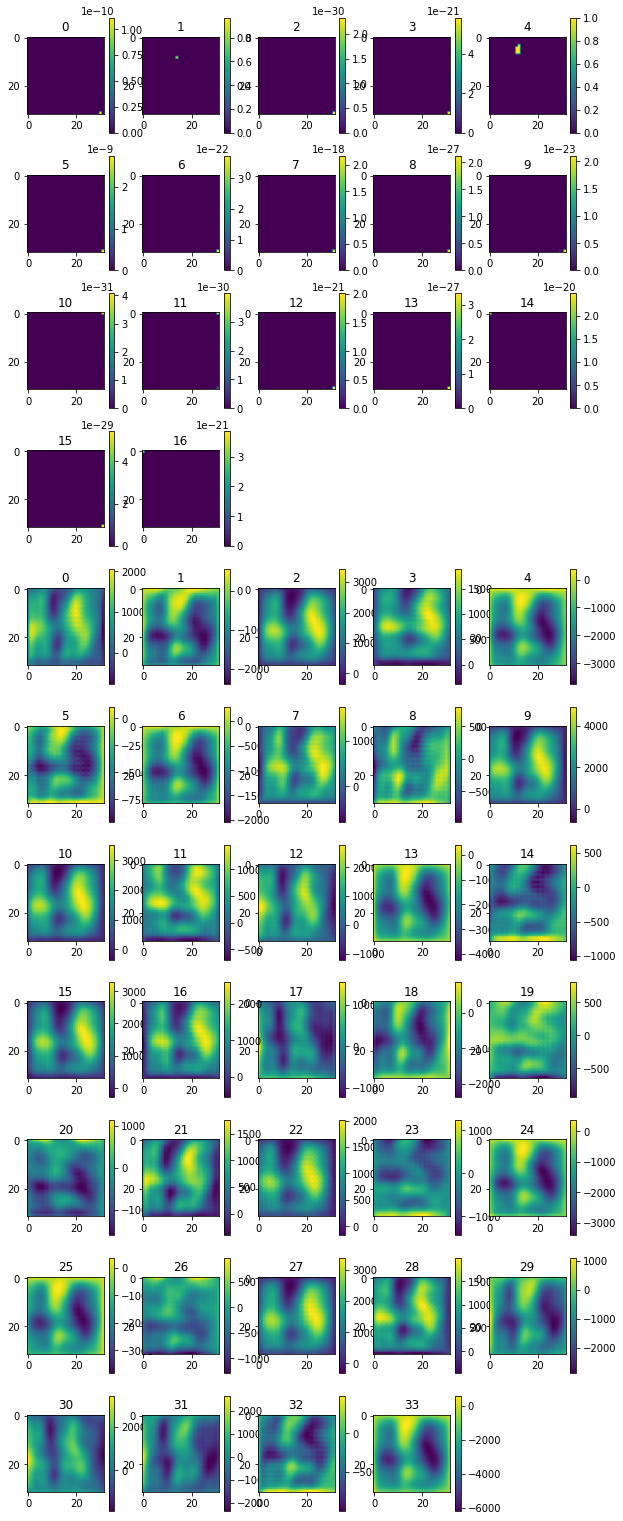

In [26]:
draw_heatmap(0, heatmap_result=result[0], offset_result=result[1])

# Decode

In [27]:
pose_scores, keypoint_scores, keypoint_coords = decode_single_poses(result[0].numpy().squeeze(axis=0),
                    result[1].numpy().squeeze(axis=0))

print(f'pose score : {pose_scores}')
print(f'keypoint scores :')
print(f'{keypoint_scores}')
print(f'keypoint coords :')
print(f'{keypoint_coords}')

pose score : [0.11572749123853796]
keypoint scores :
[0.         0.96736735 0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
keypoint coords :
[[  0.           0.        ]
 [405.23706055 453.23706055]
 [  0.           0.        ]
 [  0.           0.        ]
 [371.65921021 419.65921021]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]


In [28]:
pose_scores_nooff, keypoint_scores_nooff, keypoint_coords_nooff = decode_single_poses_nooff(result[0].numpy().squeeze(axis=0),
                    result[1].numpy().squeeze(axis=0))

print(f'pose score nooff: {pose_scores_nooff}')
print(f'keypoint scores nooff:')
print(f'{keypoint_scores_nooff}')
print(f'keypoint coords nooff:')
print(f'{keypoint_coords_nooff}')

pose score nooff: [0.11572749123853796]
keypoint scores nooff:
[0.         0.96736735 0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
keypoint coords nooff:
[[  0.           0.        ]
 [405.23706055 453.23706055]
 [  0.           0.        ]
 [  0.           0.        ]
 [371.65921021 419.65921021]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]
 [  0.           0.        ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


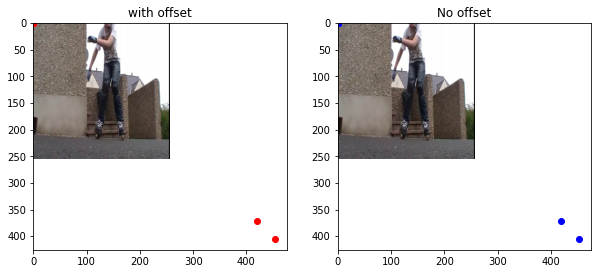

In [29]:
plt.figure(figsize=(10, 14))

plt.subplot(121)
plt.imshow(img[idx])
plt.scatter(keypoint_coords[:,1], keypoint_coords[:,0], c='red')
plt.title('with offset')

plt.subplot(122)
plt.imshow(img[idx])
plt.scatter(keypoint_coords_nooff[:,1], keypoint_coords_nooff[:,0], c='blue')
plt.title('No offset')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


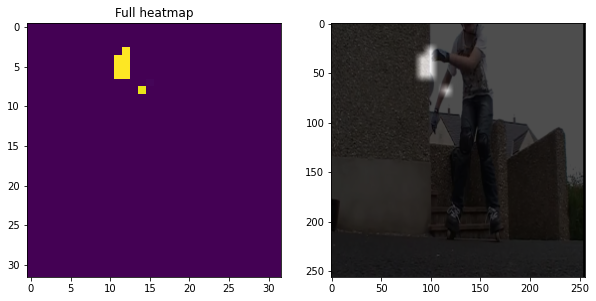

In [30]:
hm = np.sum(result[0].numpy().squeeze(axis=0), axis=2)

plt.figure(figsize=(10, 14))

plt.subplot(121)
plt.imshow(hm)
plt.title('Full heatmap')

plt.subplot(122)
plt.imshow(img[0])
plt.imshow(cv2.resize(hm, (256, 256)), alpha=0.7, cmap=plt.cm.gray)
plt.show()

In [31]:
draw_image = draw_skeleton_and_kepoints(keypoint_coords, img[idx])
plt.imshow(draw_image)
plt.show()

IndexError: too many indices for array